In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
train_df = pd.read_csv('data/dataset/sign_mnist_train.csv')
test_df = pd.read_csv('data/dataset/sign_mnist_test.csv')

In [3]:
# Rename label into Label
train_df.rename(columns={'label':'Label'},inplace = True)
test_df.rename(columns={'label':'Label'},inplace = True)

# Shuffle
train_df = train_df.sample(frac = 1.0).reset_index(drop = True)
test_df = test_df.sample(frac = 1.0).reset_index(drop = True)

In [4]:
# Show the first lines
train_df.iloc[:4,:10]

,Label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9
0,16,86,87,88,91,94,98,101,111,121
1,14,137,140,143,145,147,149,150,151,152
2,3,209,209,209,210,211,212,212,211,211
3,16,57,62,67,78,90,95,95,101,105


In [5]:
print('Number of images in the training set: ',train_df.shape[0])
print('Number of images in the test set: ', test_df.shape[0])

d = int((train_df.shape[1] - 1)**0.5)
print('Shape of the images: ', d, 'x', d)

Number of images in the training set:  29889
Number of images in the test set:  9452
Shape of the images:  28 x 28


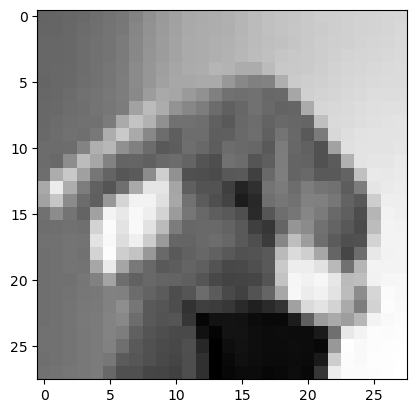

In [6]:
def to_image(array, label = True):
    # Reshape an array into an image format
    array = np.array(array)
    start_idx = 1 if label else 0
    return array[start_idx:].reshape(28,28).astype(float)
        
# Display one image
img = to_image(train_df.iloc[0])
plt.imshow(img, cmap = 'gray')
plt.show()

In [7]:
# The labels are coded in numbers. 
# Create a mapping to get the letters corresponding to the numbers
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {}

for i,l in enumerate(alphab):
    mapping_letter[l] = i
mapping_letter = {v:k for k,v in mapping_letter.items()}
mapping_letter[26] = 'next'
mapping_letter[27] = 'space'

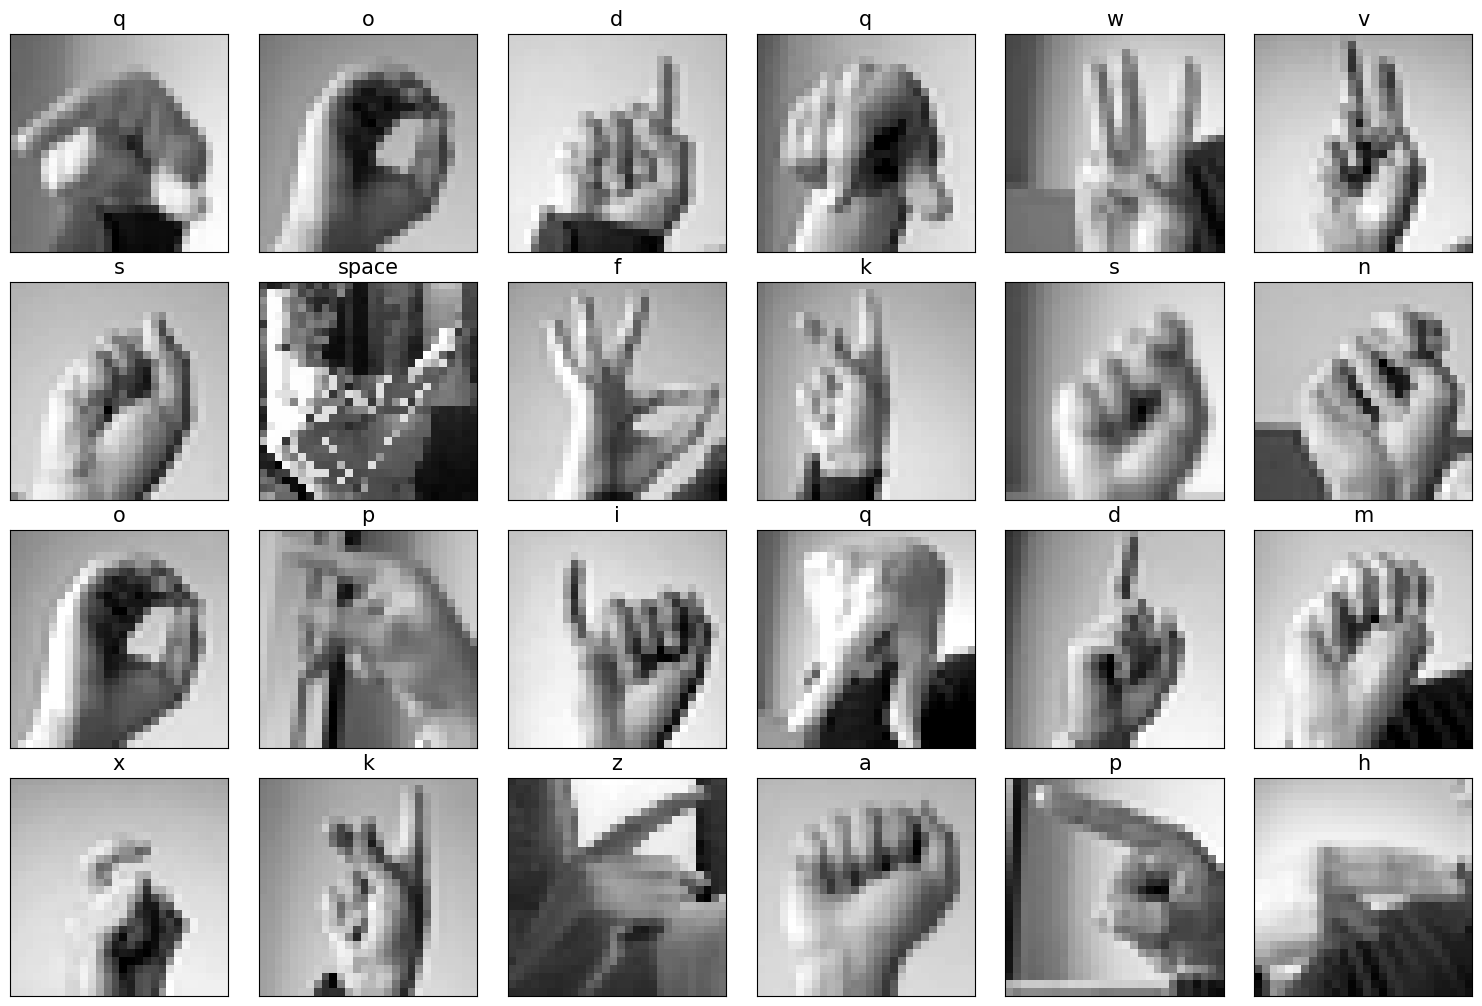

In [8]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = to_image(train_df.iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = mapping_letter[train_df.Label[i]]
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


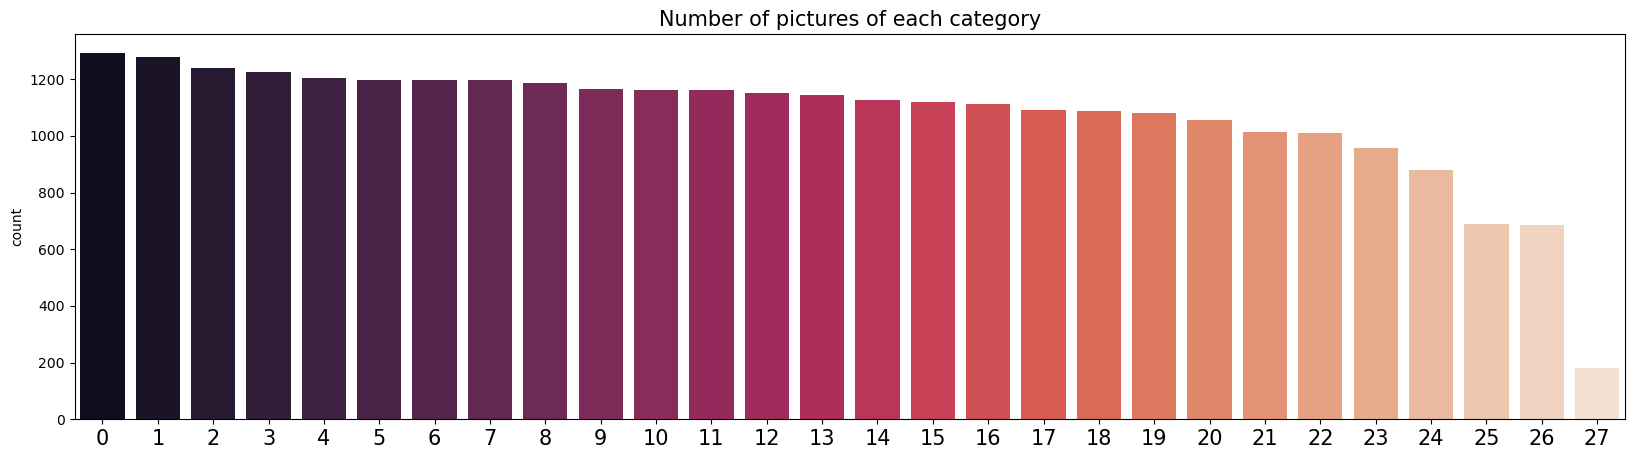

In [9]:
# Display the number of pictures of each letter
vc = train_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

# 2. Split the data and create the generator<a class="anchor" id="2"></a>

In [10]:
train_df_original = train_df.copy()

# Split into training, test and validation sets
val_index = int(train_df.shape[0]*0.1)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

y_train = train_df['Label']
y_val = val_df['Label']
y_test = test_df['Label']

# Reshape the traing and test set to use them with a generator
X_train = train_df.drop('Label',axis = 1).values.reshape(train_df.shape[0], 28, 28, 1)
X_val = val_df.drop('Label',axis = 1).values.reshape(val_df.shape[0], 28, 28, 1)
X_test = test_df.drop('Label',axis = 1).values.reshape(test_df.shape[0], 28, 28, 1)

In [11]:
# Display the shapes of the sets
X_train.shape, X_val.shape, X_test.shape

((26901, 28, 28, 1), (2988, 28, 28, 1), (9452, 28, 28, 1))

In [12]:
# Data augmentation
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")

X_train_flow = generator.flow(X_train, y_train, batch_size=32)
X_val_flow = generator.flow(X_val, y_val, batch_size=32)
# X_test_flow = generator.flow(X_test, y_test)

# 3. Create and train the model <a class="anchor" id="3"></a>

In [13]:
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Flatten(),
                    
                    Dense(units=1024, activation="relu"),                 
                    Dense(units=256, activation="relu"),
                    Dropout(0.5),
                    Dense(units=28, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         590336    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 512)         0

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow, 
                    validation_data=X_val_flow, 
                    epochs=100,
                    callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True), 
                        
                            learning_rate_reduction
                    ])

Epoch 1/100
841/841 [==============================] - 31s 36ms/step - loss: 1.5789 - accuracy: 0.4933 - val_loss: 0.4186 - val_accuracy: 0.8621 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 30s 35ms/step - loss: 0.2797 - accuracy: 0.9054 - val_loss: 0.1019 - val_accuracy: 0.9685 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 30s 36ms/step - loss: 0.1117 - accuracy: 0.9646 - val_loss: 0.0277 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 30s 36ms/step - loss: 0.0646 - accuracy: 0.9799 - val_loss: 0.0275 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9833
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
841/841 [==============================] - 30s 36ms/step - loss: 0.0542 - accuracy: 0.9833 - val_loss: 0.0273 - val_accuracy: 0.9903 - lr: 0.0010
Epoch 6/100
841/841 [============================

# 4. Visualize the result <a class="anchor" id="4"></a>

In [15]:
# Predict the label of the test_images
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
print('accuracy on the test set', acc*100)

296/296 [==============================] - 2s 8ms/step
accuracy on the test set 92.9327126534067


In [16]:
# Map the numbers into letters
y_test_letters = [mapping_letter[x] for x in y_test]
pred_letters = [mapping_letter[x] for x in pred]

In [17]:
print(classification_report(y_test_letters,pred_letters))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00       331
           b       1.00      0.95      0.97       432
           c       0.46      1.00      0.63       310
           d       1.00      0.94      0.97       245
           e       0.96      1.00      0.98       498
           f       1.00      1.00      1.00       247
           g       1.00      0.99      0.99       348
           h       1.00      0.99      0.99       436
           i       1.00      1.00      1.00       288
           j       0.00      0.00      0.00       180
           k       1.00      1.00      1.00       331
           l       0.92      1.00      0.96       209
           m       1.00      1.00      1.00       394
           n       1.00      1.00      1.00       291
        next       0.99      0.99      0.99       734
           o       0.98      1.00      0.99       246
           p       0.97      1.00      0.98       347
           q       0.78    

In [18]:
def calculate_accuracy(TP, TN, FP, FN):
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

In [19]:
# Function to calculate the confusion matrix
mapping_letter = {v:k for k,v in mapping_letter.items()}

def create_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        cm[mapping_letter[true_label]][mapping_letter[pred_label]] += 1
    return cm

In [20]:
# Function to extract TP, TN, FP, FN
def extract_metrics(cm):
    num_classes = cm.shape[0]
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    return TP, TN, FP, FN

In [21]:
def summarize_metrics(TP, TN, FP, FN):
    # Summarize TP, TN, FP, FN into a 2x2 confusion matrix
    TP_sum = np.sum(TP)
    TN_sum = np.sum(TN)
    FP_sum = np.sum(FP)
    FN_sum = np.sum(FN)
    
    # Create the summarized confusion matrix
    summarized_cm = np.array([[TN_sum, FP_sum], [FN_sum, TP_sum]])
    
    return summarized_cm

In [22]:
cm = create_confusion_matrix(y_test_letters, pred_letters, len(set(y_test_letters)))

In [23]:
TP, TN, FP, FN = extract_metrics(cm)

In [24]:
accuracies = []
for tp, tn, fp, fn in zip(TP, TN, FP, FN):
    accuracy = calculate_accuracy(tp, tn, fp, fn)
    accuracies.append(accuracy)

# Print accuracies for each label
for i, acc in enumerate(accuracies):
    print(f"Label {i + 1}: Accuracy = {acc:.4f}")

Label 1: Accuracy = 1.0000
Label 2: Accuracy = 0.9976
Label 3: Accuracy = 0.9614
Label 4: Accuracy = 0.9985
Label 5: Accuracy = 0.9977
Label 6: Accuracy = 0.9999
Label 7: Accuracy = 0.9994
Label 8: Accuracy = 0.9995
Label 9: Accuracy = 1.0000
Label 10: Accuracy = 0.9804
Label 11: Accuracy = 0.9999
Label 12: Accuracy = 0.9980
Label 13: Accuracy = 1.0000
Label 14: Accuracy = 1.0000
Label 15: Accuracy = 0.9995
Label 16: Accuracy = 0.9987
Label 17: Accuracy = 0.9952
Label 18: Accuracy = 1.0000
Label 19: Accuracy = 1.0000
Label 20: Accuracy = 1.0000
Label 21: Accuracy = 1.0000
Label 22: Accuracy = 1.0000
Label 23: Accuracy = 0.9995
Label 24: Accuracy = 1.0000
Label 25: Accuracy = 1.0000
Label 26: Accuracy = 0.9545
Label 27: Accuracy = 0.9989
Label 28: Accuracy = 0.9801


In [25]:
# Summarize the metrics into a confusion matrix
summarized_cm = summarize_metrics(TP, TN, FP, FN)

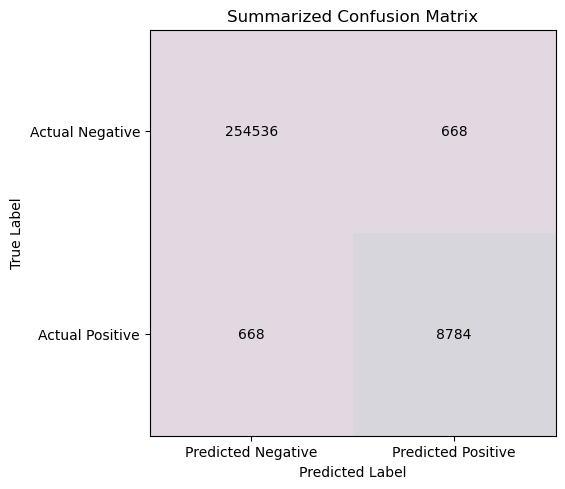

In [26]:
# Plot the summarized confusion matrix using matplotlib
plt.imshow(summarized_cm, interpolation='nearest', cmap=plt.cm.twilight)
plt.title('Summarized Confusion Matrix')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.grid(visible=False)
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(summarized_cm[i][j]), horizontalalignment='center', verticalalignment='center', color='black')
plt.show()

In [27]:
model_save_path = 'sign_language_model.h5'

model.save(model_save_path)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
